# Implicitly defined reachable sets within GCS

In [ ]:
import numpy as np
from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph, create_intermediate_line_hor_vert_graph

# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

from pydrake.all import (MathematicalProgram, MathematicalProgramResult, Solve)

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

## Simple Example Graph

In [ ]:
# g = create_simplest_hor_vert_graph()
g = create_intermediate_line_hor_vert_graph()
g.plot_sets()
g.plot_edges()
g.plot_set_labels()

In [ ]:
sol = g.solve_shortest_path()
g.plot_sets()
g.plot_edges()
g.plot_path(sol.ambient_path)
sol

In [ ]:
print(g.edge_keys)
# sol_conv_res = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

# sol_conv_res
# g.plot_sets()
# g.plot_path(sol_conv_res.ambient_path)

In [ ]:
for vertex_name, v in g.vertices.items():
    print(vertex_name, v.gcs_vertex.set().IsBounded())

# Sampling Procedure
To determine if A is dominated by B

In [ ]:
# Sample 100 points in p2
# p2_samples = np.array(g.vertices["p2"].convex_set.get_samples(100))
p3_samples = np.array(g.vertices["p3"].convex_set.get_samples(20))
g.plot_sets()
g.plot_points(p3_samples)

In [ ]:
# Project these samples into revised set based on path


def project_sample_to_revised_set(samples, vertex_sampled, active_edges):
    prog = MathematicalProgram()
    vertex_names = [g.edges[active_edges[0]].u] + [g.edges[e].v for e in active_edges]
    # gcs vertices
    vertices = [g.vertices[name].gcs_vertex for name in vertex_names]
    edges = [g.edges[edge].gcs_edge for edge in active_edges]
    vertex_vars = [prog.NewContinuousVariables(rows=samples.shape[0], cols=v.ambient_dimension(), name=f"{v_name}_vars") for v, v_name in zip(vertices, vertex_names)]
    sample_vars = vertex_vars[vertex_names.index(vertex_sampled)]
    for v, v_name, v_vars in zip(vertices, vertex_names, vertex_vars):
        if v_name == vertex_sampled:
            for x, sample in zip(v_vars, samples):
                v.set().AddPointInSetConstraints(prog, x)
                # Add the distance to the sample as a cost
                prog.AddCost((x - sample).dot(x - sample))
                # Vertex Constraints
                for binding in v.GetConstraints():
                    constraint = binding.evaluator()
                    prog.AddConstraint(constraint, x)
        else:
            for x in v_vars:
                v.set().AddPointInSetConstraints(prog, x)

                # Vertex Constraints
                for binding in v.GetConstraints():
                    constraint = binding.evaluator()
                    prog.AddConstraint(constraint, x)

    for e, e_name in zip(edges, active_edges):
        # Edge Costs
        # for binding in e.GetCosts():
        #     cost = binding.evaluator()
        #     variables = binding.variables()
        #     prog.AddCost(cost, variables)
        
        # Edge Constraints
        for binding in e.GetConstraints():
            constraint = binding.evaluator()
            variables = binding.variables()
            u_name, v_name = g.edges[e_name].u, g.edges[e_name].v
            u_idx, v_idx = vertex_names.index(u_name), vertex_names.index(v_name)
            for ux, vx in zip(vertex_vars[u_idx], vertex_vars[v_idx]):
                variables[:len(ux)] = ux
                variables[-len(vx):] = vx
                prog.AddConstraint(constraint, variables)

    result = Solve(prog)
    if not result.is_success():
        raise RuntimeError("Failed to solve")
    return result.GetSolution(sample_vars)


# active_edges = ["('s', 'p1')", "('p1', 'p2')"]
active_edges = ["('s', 'p1')", "('p1', 'p2')", "('p2', 'p3')"]
# active_edges = ["('s', 'p1')", "('p1', 'p2')", "('p2', 't')"]
new_samples = project_sample_to_revised_set(p3_samples, "p3", active_edges)
# print(new_samples)
g.plot_points(new_samples)
g.plot_sets()

# GcsAstarReachability

In [ ]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
import numpy as np

from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph, create_polyhedral_hor_vert_graph, create_intermediate_line_hor_vert_graph
# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

In [ ]:
# g = create_simplest_hor_vert_graph()
g = create_intermediate_line_hor_vert_graph()
# g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarReachability(g, cost_estimator_se, num_samples_per_vertex=5)
sol = alg.run()

In [ ]:
# g.edges["('p0', 'p0_sample_1')"]

In [ ]:
g.plot_sets()
g.plot_edges()
g.plot_set_labels()
g.plot_path(sol.ambient_path)

In [ ]:
# sol = g.solve_convex_restriction([('s', 'p1'), ('p1', 'p1_sample_0')])
# sol = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

In [ ]:
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction

g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarConvexRestriction(g, cost_estimator_se)
sol = alg.run()

Note how GcsAstarConvexRestriction fails because it doesn't have the sampling to determine reachability procedure that GcsAstarReachability has

# Applying GcsAstarReachability to Contact Graph that fails for GcsAstarConvexRestriction
cg_maze_b1

In [5]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
from large_gcs.algorithms.search_algorithm import SearchNode

import numpy as np
from IPython.display import HTML

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.INFO)

In [8]:
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams

# cg_maze_b1_1 cg_maze_b1
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_maze_b1")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)
cost_estimator = ShortcutEdgeCE(
    cg,
    shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted,
)
alg = GcsAstarReachability(cg, cost_estimator, num_samples_per_vertex=5)
sol: ShortestPathSolution = alg.run()


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 41943.04it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9765.55it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 48.02it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:00<00:00, 620.32it/s]
INFO:large_gcs.algorithms.gcs_astar_reachability:Running GcsAstarReachability
INFO:large_gcs.algorithms.gcs_astar_reachability:
n_vertices_expanded: {0: 1}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node source's 1 neighbors (0)
INFO:large_gc

RuntimeError: Solver Mosek failed to solve the Chebyshev center problem; it terminated with SolutionResult InfeasibleConstraints). Make sure that your polyhedron is bounded and has an interior.

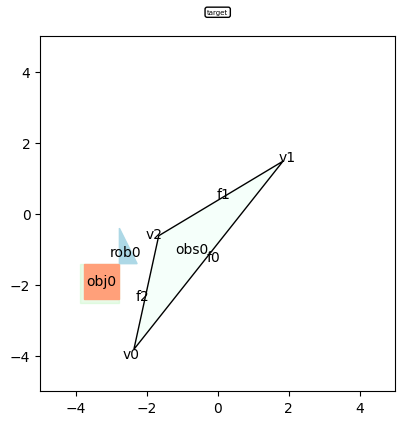

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())


In [ ]:

v_path = ['source', "('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f0-rob0_v1')", "('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')"]
n = SearchNode(priority=544.4999870205717, 
                  vertex_name="('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')", 
                  edge_path=[
                      '(\'source\', "(\'NC|obs0_f1-obj0_v1\', \'NC|obs0_f0-rob0_v1\', \'NC|obj0_f0-rob0_v1\')")', 
                      '("(\'NC|obs0_f1-obj0_v1\', \'NC|obs0_f0-rob0_v1\', \'NC|obj0_f0-rob0_v1\')", "(\'NC|obs0_f1-obj0_v1\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_f1-rob0_f1\')")', 
                      '("(\'NC|obs0_f1-obj0_v1\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_f1-rob0_f1\')", "(\'NC|obs0_f1-obj0_v1\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_f0-rob0_v1\')")'
                      ], 
                vertex_path=[
                    'source', 
                    "('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f0-rob0_v1')", 
                    "('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", 
                    "('NC|obs0_f1-obj0_v1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')"
                    ]
                )
# alg._graph.generate_and_plot_samples_in_set(n.vertex_name, n_samples=1)
# alg._graph.set_target(n.vertex_name)
# alg._graph.solve_convex_restriction(n.edge_path)
# alg._graph.plot_path()
# anim = alg._graph.animate_solution()
# HTML(anim.to_html5_video())
# alg._graph.plot()
proj_samples = alg._set_samples[n.vertex_name].project(alg._graph, n)
alg._graph.plot_samples_in_set(n.vertex_name, proj_samples)


The equality constraints on edges can collapse the feasible region in the next set to some measure 0 subspace which then have probability 0 of being sampled